In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import xml.etree.ElementTree as ET
import json
import time
import utils

In [2]:
coin_labels = ('10c', '20c', '50c', '$1', '$2', '$5', '$10')
label_index_dict = {k:v+1 for v, k in enumerate(coin_labels)}
label_index_dict['background'] = 0
index_label_dict = {v+1:k for v, k in enumerate(coin_labels)}
index_label_dict[0] = 'background'

print(label_index_dict)
print(index_label_dict)

{'10c': 1, '20c': 2, '50c': 3, '$1': 4, '$2': 5, '$5': 6, '$10': 7, 'background': 0}
{1: '10c', 2: '20c', 3: '50c', 4: '$1', 5: '$2', 6: '$5', 7: '$10', 0: 'background'}


In [3]:
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    boxes = list()
    labels = list()
    # difficulties = list()
    for object in root.iter('object'):

        # difficult = int(object.find('difficult').text == '1')

        label = object.find('name').text.lower().strip()
        if label not in label_index_dict:
            continue
        # TODO: might have to change normalize values of coordinates
        bbox = object.find('bndbox')
        # TODO: why minus 1?
        xmin = int(bbox.find('xmin').text) - 1
        ymin = int(bbox.find('ymin').text) - 1
        xmax = int(bbox.find('xmax').text) - 1
        ymax = int(bbox.find('ymax').text) - 1

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_index_dict[label])

    return {'boxes': boxes, 'labels': labels}

In [13]:
from glob import glob
from pathlib import Path

ch_files = glob(r'dataset/Chin Hui Labelled Data/*.xml')
# jy_files = glob(r'dataset/joey dataset/*.xml')
# hw_files = glob(r'dataset/hw dataset/*.xml')

# save as 2 separate json objects, one for images, one for bounding box values and objects
def xml_to_json(files):
    images_list = [] 
    objects_list = [] # file: boxes: [], labels: []
    image_f = open("TRAIN_images.json", 'w')
    objects_f = open("TRAIN_objects.json", 'w')
    for file in files:
        file_name = Path(file).stem
        file_path = os.path.splitext(file)[0]
        xml_dict = parse_annotation(file)
        objects_list.append(xml_dict)
        images_list.append(file_path + ".jpg")

    json.dump(images_list, image_f)
    json.dump(objects_list, objects_f)

xml_to_json(ch_files)
# xml_to_json(jy_files)
# xml_to_json(hw_files)

In [14]:
from torchvision import transforms

class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """
    # TODO: Scale down images
    def __init__(self, data_folder, split):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        """
        self.split = split.upper()

        assert self.split in {'TRAIN', 'TEST'}

        self.data_folder = data_folder

        # Read data files
        with open(os.path.join(data_folder, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split + '_objects.json'), 'r') as j:
            self.objects = json.load(j)

        assert len(self.images) == len(self.objects)

    def __getitem__(self, i):
        # Read image
        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')
        image_tensor = transforms.ToTensor()(image)
        image_tensor = transforms.Resize(size=(300,423))(image_tensor)

        # Read objects in this image (bounding boxes, labels)
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects['boxes'])/10 # (n_objects, 4)
        labels = torch.LongTensor(objects['labels'])  # (n_objects)

        # Apply transformations
        # image, boxes, labels, difficulties = transform(image, boxes, labels, split=self.split)

        return image_tensor, boxes, labels

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
        This describes how to combine these tensors of different sizes. We use lists.
        Note: this need not be defined in this Class, can be standalone.
        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])

        images = torch.stack(images, dim=0)
        return images, boxes, labels  # tensor (N, 3, 300, 300), 3 lists of N tensors each

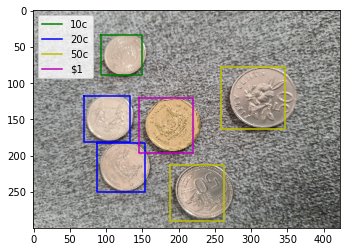

In [18]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

color_maps = ['r', 'g', 'b', 'y', 'm', 'w', 'k', 'c']
bs = 10
dataset = PascalVOCDataset(".", "TRAIN")
train_dataloader = DataLoader(dataset, batch_size=bs, shuffle=True, collate_fn = dataset.collate_fn)

# Visualise data
for data in train_dataloader:
    for batch in range(bs):
        img = data[0][batch]
        boxes = data[1][batch]
        labels = data[2][batch].tolist()
        named_labels = [index_label_dict[label] for label in labels]
        plt.imshow(transforms.ToPILImage()(img))
        ax = plt.gca()
        labelled = set()
        for i, box in enumerate(boxes):
            w,h = box[2] - box[0], box[3] - box[1]
            x,y = box[0].item(), box[1].item()
            x = [x, x+w, x+w, x, x]
            y = [y, y, y+h, y+h, y]

            label = labels[i]
            if label not in labelled:
                plt.plot(x,y, color=color_maps[label], label=index_label_dict[label])
                labelled.add(label)
            else:
                plt.plot(x,y, color=color_maps[label])
            plt.legend(loc='best')
        break
    break

In [9]:
from torch import nn
hidden_dim = 64
ob_size = 20 # TODO: how to not have fixed ob_size
nb_class_objects = 7
offset = (ob_size-1)// 2
batch_size=2
nb_objects = 3 # TODO: how to not have fixed number of objects?
im_size = 3000

class faster_R_CNN(nn.Module):
    
    def __init__(self):
        super(faster_R_CNN, self).__init__()
        # backbone convnet
        self.conv1 = nn.Conv2d(3,  hidden_dim,  kernel_size=3, padding=1 ) #  1x28x28 --> hidden_dimx 28x28 
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1 ) # hidden_dim x28x28 --> hidden_dim x28x28 
        # Bbox classes
        self.linear_class = nn.Linear(hidden_dim* ob_size**2, nb_class_objects) # hidden_dim x7x7 --> nb_class_objects 
        # Bbox anchors NOTE: kernel size is ob_size as a form of sliding window, filters are ob_size * ob_size
        self.conv_anch = nn.Conv2d(hidden_dim, 1, kernel_size=ob_size, padding=offset )  # hidden_dim x28x28 --> 1x28x28 
        
    def forward(self, x, bb, train_flag=True):
        # backbone convnet
        x = self.conv1(x) # [batch_size, hidden_dim, im_size, im_size] 
        x = torch.relu(x)
        x = self.conv2(x) # [batch_size,hidden_dim, im_size, im_size]
        x = torch.relu(x) 
        # Bbox anchors
        scores_bbox_anch = self.conv_anch(x).squeeze() # [batch_size, im_size, im_size] 
        # Bbox classes
        if train_flag: # forward pass at training time
            bbox = []
            for b in range(batch_size):
                for k in range(nb_objects):
                    x1,y1 = bb[b][k,0].long(), bb[b][k,1].long()
                    x2,y2 = bb[b][k,2].long(), bb[b][k,3].long()
                    # w,h = x2-x1, y2-y1
                    bbox.append(x[b,:,x1:x2,y1:y2])
            # BUG: RuntimeError: stack expects each tensor to be equal size, but got [64, 33, 32] at entry 0 and [64, 40, 40] at entry 1
            # Problem: with size of objects being different
            bbox = torch.stack(bbox, dim=0) # [batch_size*nb_objects, hidden_dim, ob_size, ob_size]
            bbox = bbox.view(-1, hidden_dim * ob_size**2) # [batch_size*nb_objects, hidden_dim*ob_size*ob_size]
            scores_bbox_class = self.linear_class(bbox) # [batch_size*nb_objects, nb_class_objects]
        else: # forward pass at test time
            batch_bbox = []
            for b in range(batch_size):
                # compute the coordinates of the top-K bbox anchor scores (K=nb_objects)
                scores_bbox_anch_b = scores_bbox_anch[b,:,:] # [im_size, im_size]
                scores_bbox_anch_b = scores_bbox_anch_b.view(-1) # [im_size*im_size]
                _, idx_largest = torch.sort(scores_bbox_anch_b, descending=True) # [im_size*im_size]
                idx_largest = idx_largest[:nb_objects] # [nb_objects]
                idx_y = idx_largest//im_size # [nb_objects]
                idx_x = idx_largest - idx_y*im_size # [nb_objects]
                # extract the top-K bboxes of size [batch_size, nb_objects, hidden_dim, ob_size, ob_size]
                # COMPLETE HERE
                bbox = []
                for k in range(nb_objects):
                    bbox.append(x[b,:,idx_y[k]-offset:idx_y[k]-offset+ob_size,idx_x[k]-offset:idx_x[k]-offset+ob_size])
                bbox = torch.stack(bbox, dim=0) # [nb_objects, hidden_dim, ob_size, ob_size]
                bbox = bbox.view(-1, hidden_dim * ob_size**2) # [nb_objects, hidden_dim*ob_size*ob_size]
                batch_bbox.append(bbox)
            # compute the class scores of the bbox
            # size of tensor scores_bbox_class is [batch_size*nb_objects, nb_class_objects]
            # COMPLETE HERE
            batch_bbox = torch.cat(batch_bbox, dim=0) # [batch_size*nb_objects, hidden_dim*ob_size*ob_size]
            scores_bbox_class = self.linear_class(batch_bbox) # [batch_size*nb_objects, nb_class_objects]
        return scores_bbox_class, scores_bbox_anch

In [26]:
# device = torch.device('cuda')
device = torch.device('cpu')

In [27]:
net = faster_R_CNN()
net.to(device)
print(net)
print(utils.display_num_param(net))

faster_R_CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear_class): Linear(in_features=25600, out_features=7, bias=True)
  (conv_anch): Conv2d(64, 1, kernel_size=(20, 20), stride=(1, 1), padding=(9, 9))
)
There are 243528 (0.24 million) parameters in this neural network
None


In [28]:
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
running_loss = 0
num_batches = 0
start = time.time()
for epoch in range(10):
    for data in train_dataloader:
        batch_images, batch_bboxes = data[0], data[1]
        optimizer.zero_grad()
        scores_bbox_class, scores_bbox_anch = net(batch_images, batch_bboxes)
        # Bbox class loss
        labels_bbox_class = batch_bboxes[:,:,4].long().view(-1) # [batch_size*nb_objects]
        loss_class = nn.CrossEntropyLoss()(scores_bbox_class, labels_bbox_class)
        # Bbox anchors loss
        labels_bbox_coord = batch_bboxes[:,:,0:2] # [batch_size, nb_objects, 2D]
        labels_bbox_anch = torch.zeros(batch_size, im_size, im_size) # [batch_size, im_size, im_size]
        for b in range(batch_size):
            for k in range(nb_objects): 
                labels_bbox_anch[b,labels_bbox_coord[b,k,1].long(),labels_bbox_coord[b,k,0].long()] = 1
        loss_anch = torch.nn.BCEWithLogitsLoss()(scores_bbox_anch, labels_bbox_anch)
        loss = loss_class + loss_anch
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().item()
        num_batches += 1

    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', init_lr  ,'\t loss=', total_loss )

IndexError: index 2 is out of bounds for dimension 0 with size 2